# CNN : because we are doing image classification

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/dGtDTjYs3xc?si=9Hanq6-xgkE9HSWu" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

# READ IN POTATO DATASET from KAGGLE

In [40]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"C:/Users/Public/lmaaya/data/DeepLearning/datasets/Potato Project/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
68*32

2176

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 1 0 0 0 0 1 0 0 1 2 0 1 1 0 0 1 1 1 0 2 1 1 1 1 1 0 0 1 0 1]


In [9]:
#for image_batch, label_batch in dataset.take(1):
 #   print(image_batch[0].numpy(), image_batch[0].shape)

# VISUALIZING THE IMAGES

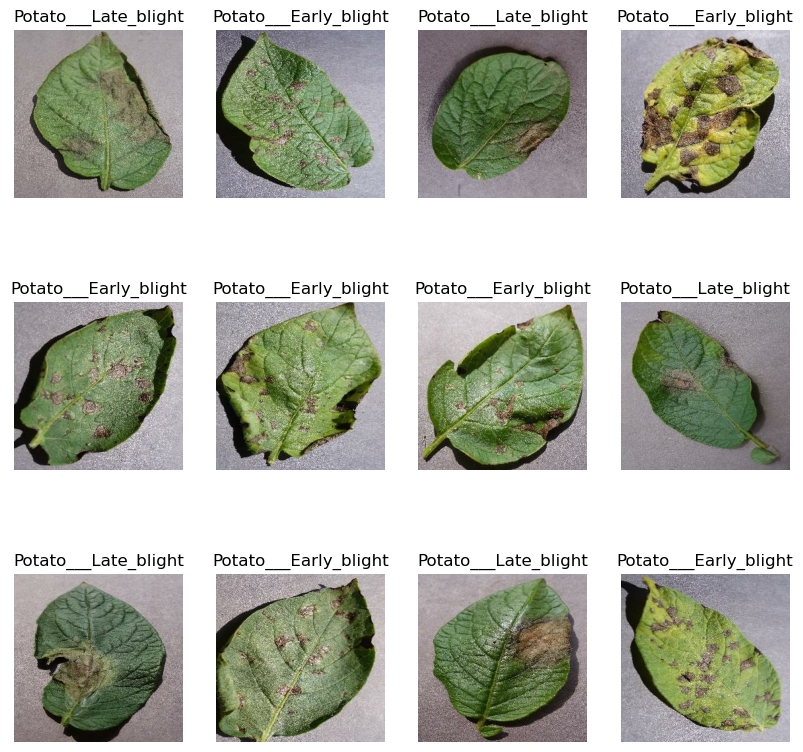

In [10]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# SPLIT INTO TRAIN, TEST

In [11]:
len(dataset)

68

80% ==> training
20% ==> 10% validation, 10% test

In [12]:
train_size = 80/100

len(dataset)* train_size # tensorflow does not have train_test_split

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
rem_ds = dataset.skip(54)
len(rem_ds)

14

In [15]:
val_size = 10/100
len(dataset)* val_size

6.800000000000001

In [16]:
val_ds = rem_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = rem_ds.skip(6)
len(test_ds)

8

# All the above steps for creating test, train and validation data in a function

In [18]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

# Catching and pre-fetching to improve performance

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# preprocessing: scaling, data augmentation....

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)


])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax')

])

model.build(input_shape= input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [26]:
model.compile(
    
    optimizer= 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']

)

In [27]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds

)

Epoch 1/50
54/54 [==============================] - 79s 1s/step - loss: 0.9096 - accuracy: 0.4786 - val_loss: 0.9146 - val_accuracy: 0.5521
Epoch 2/50
54/54 [==============================] - 69s 1s/step - loss: 0.8255 - accuracy: 0.6481 - val_loss: 0.6343 - val_accuracy: 0.7865
Epoch 3/50
54/54 [==============================] - 71s 1s/step - loss: 0.5548 - accuracy: 0.7691 - val_loss: 0.5164 - val_accuracy: 0.7708
Epoch 4/50
54/54 [==============================] - 69s 1s/step - loss: 0.3961 - accuracy: 0.8322 - val_loss: 0.3341 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 69s 1s/step - loss: 0.3002 - accuracy: 0.8814 - val_loss: 0.3290 - val_accuracy: 0.8385
Epoch 6/50
54/54 [==============================] - 69s 1s/step - loss: 0.2605 - accuracy: 0.8987 - val_loss: 0.3591 - val_accuracy: 0.8542
Epoch 7/50
54/54 [==============================] - 67s 1s/step - loss: 0.2483 - accuracy: 0.8999 - val_loss: 0.2153 - val_accuracy: 0.8802
Epoch 8/50
54/54 [==

In [28]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 9s 328ms/step - loss: 0.3965 - accuracy: 0.8906


[0.39652910828590393, 0.890625]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
len(history.history['accuracy'])

50

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

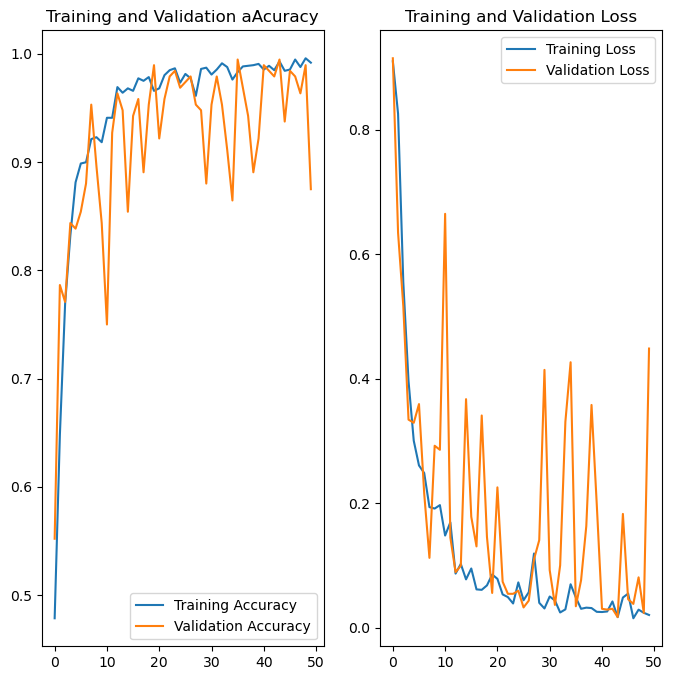

In [38]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation aAcuracy")


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")


[[[166 152 152]
  [163 149 149]
  [158 144 144]
  ...
  [205 200 197]
  [201 196 193]
  [198 193 190]]

 [[167 153 153]
  [158 144 144]
  [135 121 121]
  ...
  [202 197 194]
  [201 196 193]
  [199 194 191]]

 [[160 146 146]
  [140 126 126]
  [134 120 120]
  ...
  [199 194 191]
  [199 194 191]
  [200 195 192]]

 ...

 [[130 118 122]
  [153 141 145]
  [174 162 166]
  ...
  [181 174 181]
  [181 174 181]
  [181 174 181]]

 [[138 126 130]
  [104  92  96]
  [144 132 136]
  ...
  [182 175 182]
  [182 175 182]
  [183 176 183]]

 [[113 101 105]
  [181 169 173]
  [150 138 142]
  ...
  [185 178 185]
  [186 179 186]
  [187 180 187]]]
first image to predict
first image's actual label:  Potato___Late_blight
1/1 [==============================] - 0s 324ms/step
predicted label:  Potato___Early_blight


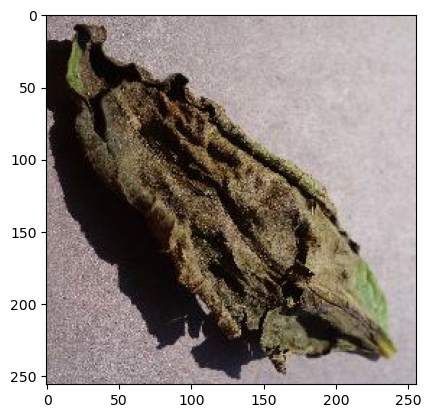

In [41]:
for images_batch, labels_batch in test_ds.take(1):
    
    print(images_batch[0].numpy().astype('uint8'))
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


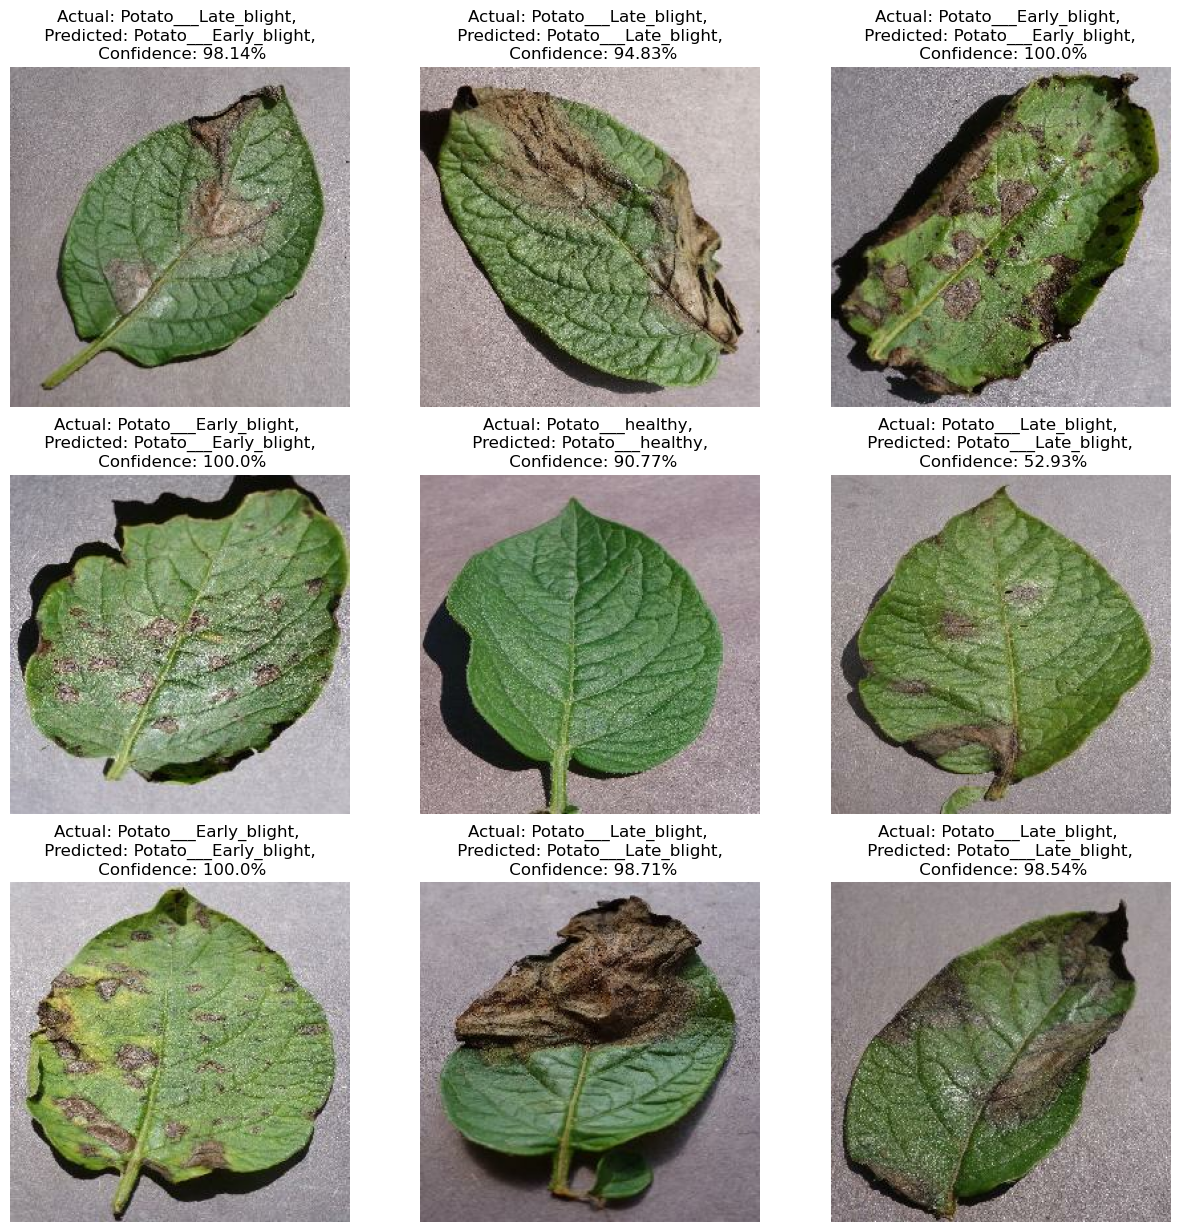

In [45]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis('off')

In [48]:
model_version = 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


# AUTOMATE MODEL VERSIONS INSTEAD OF MANUALLY SPECIFYING THE MODEL VERSION AS ABOVE


In [50]:
#import os
#model_version = max([int(i) for i in os.listdir("models") + [0]]) + 1
#model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets
